In [2]:
from pydub import AudioSegment
from pydub.playback import play
from pydub import silence
import thesis_functions as tf
from scipy.io import wavfile
import noisereduce as nr
from joblib import load, dump
from functions import show_audio_plot
import os
import librosa
import numpy as np
import scipy
import tempfile
from pydub.effects import normalize

In [3]:
from presets import Preset
import librosa as _librosa
librosa = Preset(_librosa)
librosa['sr'] = 44100
librosa['n_fft'] = 4096
librosa['hop_length'] = 1024

In [256]:
samples = load('/media/emile/disk/chatbot_normalized_segmented_30db.pkl')

In [257]:
def audiosegment_to_ndarray(audiosegment):
    samples = audiosegment.get_array_of_samples()
    samples_float = librosa.util.buf_to_float(samples,n_bytes=2,
                                      dtype=np.float32)
    if audiosegment.channels==2:
        sample_left= np.copy(samples_float[::2])
        sample_right= np.copy(samples_float[1::2])
        sample_all = np.array([sample_left,sample_right])
    else:
        sample_all = samples_float
        
        
    return [sample_all,audiosegment.frame_rate]

In [258]:
import warnings
warnings.filterwarnings("ignore")

def detect_noisy_parts(audio_seg, rms_threshold, frame_length, hop_length):
    # Load the audio file
    y, sr = audiosegment_to_ndarray(audio_seg)

    # Calculate the root mean square (RMS) energy for each frame
    rms = librosa.feature.rms(y, frame_length=frame_length, hop_length=hop_length)[0]

    # Find the frames where the RMS energy is above the threshold
    noisy_frames = np.where(rms > rms_threshold)[0]

    return len(noisy_frames) > 0


In [259]:
def noise_reduce_audio(audioseg, prop_decrease=1, thres_n_mult_nonstationairy=2, stationairy=False, n_jobs=-1):
    # load data
    rate = audioseg.frame_rate
    data = np.array(audioseg.get_array_of_samples())
    print(rate, data)
    # perform noise reduction
    reduced_noise = nr.reduce_noise(y=data, sr=rate, prop_decrease=prop_decrease, thresh_n_mult_nonstationary=thres_n_mult_nonstationairy, stationary=stationairy, n_jobs=n_jobs)

    tmp = tempfile.TemporaryFile(dir=".",suffix=".wav")
    
    wavfile.write(tmp, rate, reduced_noise)
    reduced = AudioSegment.from_file_using_temporary_files(file=tmp, format="wav")
    return reduced

In [260]:
rms_threshold = 0.35  # Set the threshold according to your specific requirements
frame_length = 4096  # The length of the analysis window in samples
hop_length = 1024  # The number of samples between successive frames

In [261]:
# test_rms_threshold = 0.26

# test_sounds = []

# # add all .wav files from 'test_samples' folder as AudioSegment to test_sounds list
# for file in os.listdir('test_samples'):
#     if file.endswith('.wav'):
#         test_sounds.append(AudioSegment.from_wav(os.path.join('test_samples', file)))

# noisy = []
# not_noisy = []
# for x in test_sounds:
#     if(detect_noisy_parts(x, test_rms_threshold, frame_length, hop_length)):
#         noisy.append(x)
#     else:
#         not_noisy.append(x)

# print(len(noisy), len(not_noisy))

In [262]:
noisy_samples = {}

# Loop over all files in the directory
for user in samples:
    noisy_samples[user] = {}
    for conv in samples[user]:
        noisy_samples[user][conv] = []
        for sample in samples[user][conv]:
            # Detect noisy parts in the audio file
            has_noisy_parts = detect_noisy_parts(sample, rms_threshold, frame_length, hop_length)
            # If the audio file has noisy parts, add it to the list
            if has_noisy_parts:
                noisy_samples[user][conv].append(sample)


for user in samples:
    for conv in samples[user]:
        samples[user][conv] = [sample for sample in samples[user][conv] if sample not in noisy_samples[user][conv]]

In [263]:
def show_audio_plot_audioseg(audioseg):
    AudioSegment.export(audioseg,'temp_audioseg.wav', format='wav')
    show_audio_plot('temp_audioseg.wav', 'og')
    os.remove('temp_audioseg.wav')

In [264]:
# users with very bad audio quality
unwanted_user = ['User_05_CB', #out
'User_10_CB', #maybe
'User_33_CB', #out
'User_37_CB', #out
'User_41_CB', #out
'User_42_CB', #out
'User_51_CB', #out
]

# Remove them from the samples
for user in unwanted_user:
    if user + "_Conversations" in samples.keys():
        samples.pop(user + "_Conversations")


In [265]:
# user_list = list(samples.keys())
# user = user_list[6]
# conv_idx = -1
# sample_idx = -1

# print(user)
# # user += '_Conversations'
# convs = list(samples[user].keys())
# samples[user]
# print("Samples in conv", len(samples[user][convs[conv_idx]]))
# test_sound = samples[user][convs[conv_idx]][sample_idx]
# show_audio_plot_audioseg(test_sound)
# reduced_test_sound = normalize(noise_reduce_audio(test_sound))
# redeced_stationairy = normalize(noise_reduce_audio(test_sound, stationairy=True))
# combined = test_sound[0:3000] + reduced_test_sound[0:3000] + redeced_stationairy[0:3000]
# # test_sound
# combined

In [266]:
# Reduce noise and normalize again

for user in samples:
    for conv in samples[user]:
        for i, sample in enumerate(samples[user][conv]):
            samples[user][conv][i] = normalize(noise_reduce_audio(sample))

44100 [5150 4604 3772 ...  562  530  517]
44100 [-124 -122 -128 ...  322  232  238]
44100 [-424 -526 -460 ...   -4  -40  -38]
44100 [ -597  -908 -1112 ...    98   180   183]
44100 [-295 -305 -280 ... -388 -465 -421]
44100 [-154 -174 -133 ... -222 -249 -247]
44100 [ -41  -18   -4 ... -153 -126 -133]
44100 [-148 -131 -129 ... -553 -591 -552]
44100 [ -55  -32  -30 ... -325 -362 -358]
44100 [304 327 307 ... 205 259 292]
44100 [-441 -450 -438 ...  -31  -47  -24]
44100 [ 241  239  249 ... -214 -240 -216]
44100 [  97  123  160 ... -145 -123 -103]
44100 [-1170 -1401 -1325 ...   100    19    44]
44100 [-313 -372 -321 ...  287  270  283]
44100 [ 137  142  147 ... -448 -459 -417]
44100 [236 259 218 ... -31 -36  -6]
44100 [-21 -27 -58 ... -41 -39 -19]
44100 [-584 -606 -571 ...  168  173  219]
44100 [-2353 -2863 -2909 ...   350   374   414]
44100 [367 424 374 ...  94 144 173]
44100 [-7627 -8688 -8701 ...   -50   -65   -86]
44100 [-78 -76 -47 ... 126 206 152]
44100 [3608 3944 3633 ... -406 -356 -267

In [267]:
# os.remove('/media/emile/disk/chatbot_noise_reduced_normalized_segmented_30db.pkl')

In [268]:
# dump(samples, '/media/emile/disk/chatbot_noise_reduced_normalized_segmented_30db.pkl')

['/media/emile/disk/chatbot_noise_reduced_normalized_segmented_30db.pkl']

In [28]:
samples = load('/media/emile/disk/chatbot_noise_reduced_normalized_segmented_30db.pkl')

In [29]:
def lengths_of_samples(samples):
    lengths = []
    for user in samples:
        for conv in samples[user]:
            for sample in samples[user][conv]:
                lengths.append(len(sample))
    return lengths

In [49]:
min_target_length = 10 * 1000  # Minimum target length in milliseconds
max_target_length = 15 * 1000  # Maximum target length in milliseconds

In [50]:
new_samples = {}
left_over = {}
for user in samples.keys():
    new_samples[user] = {}
    left_over[user] = []
    for conv in samples[user].keys():
        new_samples[user][conv] = []
        part_samples = AudioSegment.silent(0)
        part_total = 0
        for i, x in enumerate(samples[user][conv]):
            if part_total + len(x) > max_target_length:  # If adding the next sample exceeds the maximum length
                if part_total >= min_target_length:  # If current total length is more than minimum target length
                    new_samples[user][conv].append(part_samples)
                else:  # If current total length is less than minimum target length, consider it as left over
                    left_over[user].append(part_samples)
                part_samples = AudioSegment.silent(0)
                part_total = 0
            part_samples += x
            part_total += len(x)

        # If there is remaining part_samples at the end of a conversation, append it to the leftovers
        if len(part_samples) > 0:
            left_over[user].append(part_samples)
            
# Now, let's handle the leftovers
for user in left_over.keys():
    new_samples[user]['leftovers'] = []
    part_samples = AudioSegment.silent(0)
    part_total = 0
    for i, x in enumerate(left_over[user]):
        if part_total + len(x) > max_target_length:  # If adding the next sample exceeds the maximum length
            if part_total >= min_target_length:  # If current total length is more than minimum target length
                new_samples[user]['leftovers'].append(part_samples)
            part_samples = AudioSegment.silent(0)
            part_total = 0
        part_samples += x
        part_total += len(x)

    # If there is remaining part_samples at the end of the leftovers, append it to the new_samples
    if len(part_samples) > 0:
        new_samples[user]['leftovers'].append(part_samples)

In [51]:
# target_length = 15 * 1000  # Target length in milliseconds


# new_samples = {}
# for user in samples.keys():
#     new_samples[user] = {}
#     for conv in samples[user].keys():
#         new_samples[user][conv] = []
#         part_samples = AudioSegment.silent(0)
#         part_total = 0
#         for i, x in enumerate(samples[user][conv]):
#             part_samples += x
#             part_total += len(x)
#             print(part_total)
            
#             if i < len(samples[user][conv]) - 1:  # Check if there is a next sample
#                 next_sample_length = len(samples[user][conv][i + 1])
#                 current_diff = abs(part_total - target_length)
#                 next_diff = abs(part_total + next_sample_length - target_length)

#                 # If the difference is smaller when the next sample is included, continue
#                 if current_diff >= next_diff:
#                     continue

#             new_samples[user][conv].append(part_samples)
#             part_samples = AudioSegment.silent(0)
#             part_total = 0

In [52]:
to_remove = {}

for user in new_samples:
    to_remove[user] = {}
    for conv in new_samples[user]:
        to_remove[user][conv] = []
        for i, sample in enumerate(new_samples[user][conv]):
            if (len(sample) < min_target_length) or (len(sample) > max_target_length):
                to_remove[user][conv].append(sample)


for user in new_samples:
    for conv in new_samples[user]:
        new_samples[user][conv] = [sample for sample in new_samples[user][conv] if sample not in to_remove[user][conv]]

In [53]:
sample_lengths = lengths_of_samples(new_samples)
larr = np.array(sample_lengths)

In [54]:
len(sample_lengths)

822

Lower 10208.525 21 10209
Upper 14900.175000000001 801 14900


IndexError: tuple index out of range

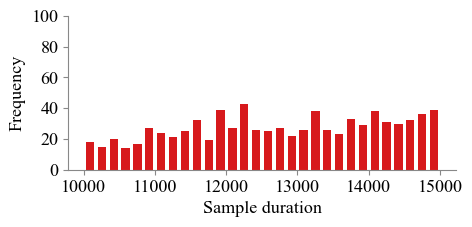

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

samples = larr
samples.sort()

fig, ax = plt.subplots(1, 1, figsize=(5,2))

# lengthdf = pd.read_pickle('db/full-chatbot-egemaps-median.pkl')

custom_lines = [Line2D([0], [0], color='#d7191c', lw=3, label='Outside 95 percentile'),
                Line2D([0], [0], color='#fdae61', lw=3, label='Inside 95 percentile')]

upper = np.percentile(samples, 97.5)
lower = np.percentile(samples, 2.5)


lower_idx = 0
upper_idx = 0
for i,x in enumerate(samples):
    if x > lower:
        lower_idx = i
        break
for i,x in enumerate(samples):
    if x > upper:
        upper_idx = i
        break
lower_bar = round(lower)
upper_bar = round(upper)
print("Lower",lower,lower_idx, lower_bar)
print("Upper",upper,upper_idx,upper_bar)



N, bins, patches = ax.hist(samples, bins=30, facecolor = '#fdae61', rwidth=0.7)
ax.set_ylim([0, 100])
ax.set(title=None)
ax.set_ylabel(ylabel='Frequency', fontname="Times New Roman", fontsize=13)
ax.set_xlabel(xlabel='Sample duration', fontname="Times New Roman", fontsize=13)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(color='#888888')
for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(13)
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(13)
for spine in ax.spines.values():
    spine.set_edgecolor('#888888')
for i in range(0,lower_bar):
    patches[i].set_facecolor('#d7191c')
for i in range(upper_bar,len(patches)):
    patches[i].set_facecolor('#d7191c')
ax.legend(handles=custom_lines, loc='upper right', bbox_to_anchor=(1.05,1.1), prop={'family': "Times New Roman", "size":13}, frameon=False)
# plt.savefig('img/length_distribution.svg')

In [56]:
list(new_samples['User_01_CB_Conversations'].values())[0][0]

In [65]:
new_samples

{'USER_01_CB2_Conversations': {'USER_01_CB2_20230131_100202': [<pydub.audio_segment.AudioSegment at 0x7fa31a1b6100>,
  'USER_01_CB2_20230131_101302': [<pydub.audio_segment.AudioSegment at 0x7fa31a17b340>],
  'USER_01_CB2_20230131_102058': [<pydub.audio_segment.AudioSegment at 0x7fa31a17b910>,
  'USER_01_CB2_20230131_102905': [<pydub.audio_segment.AudioSegment at 0x7fa31a1c6d90>],
  'USER_01_CB2_20230131_103622': [<pydub.audio_segment.AudioSegment at 0x7fa31a11e460>],
  'USER_01_CB2_20230131_104222': [<pydub.audio_segment.AudioSegment at 0x7fa31a0bf880>],
  'leftovers': [<pydub.audio_segment.AudioSegment at 0x7fa311ecea30>,
   <pydub.audio_segment.AudioSegment at 0x7fa311ece640>]},
 'User_01_CB_Conversations': {'User_01_CB_20221116_094233': [<pydub.audio_segment.AudioSegment at 0x7fa31a0d7bb0>,
  'User_01_CB_20221116_094932': [<pydub.audio_segment.AudioSegment at 0x7fa31a109b50>],
  'User_01_CB_20221116_095440': [],
  'User_01_CB_20221116_095834': [],
  'User_01_CB_20221116_100351': [<p

In [61]:
name = 'USER_01_CB2_Conversations'

In [64]:
'_'.join(name.split('_')[:3])

'USER_01_CB2'

In [69]:
new_samples

{'USER_01_CB2_Conversations': {'USER_01_CB2_20230131_100202': [<pydub.audio_segment.AudioSegment at 0x7fa31a1b6100>,
  'USER_01_CB2_20230131_101302': [<pydub.audio_segment.AudioSegment at 0x7fa31a17b340>],
  'USER_01_CB2_20230131_102058': [<pydub.audio_segment.AudioSegment at 0x7fa31a17b910>,
  'USER_01_CB2_20230131_102905': [<pydub.audio_segment.AudioSegment at 0x7fa31a1c6d90>],
  'USER_01_CB2_20230131_103622': [<pydub.audio_segment.AudioSegment at 0x7fa31a11e460>],
  'USER_01_CB2_20230131_104222': [<pydub.audio_segment.AudioSegment at 0x7fa31a0bf880>],
  'leftovers': [<pydub.audio_segment.AudioSegment at 0x7fa311ecea30>,
   <pydub.audio_segment.AudioSegment at 0x7fa311ece640>]},
 'User_01_CB_Conversations': {'User_01_CB_20221116_094233': [<pydub.audio_segment.AudioSegment at 0x7fa31a0d7bb0>,
  'User_01_CB_20221116_094932': [<pydub.audio_segment.AudioSegment at 0x7fa31a109b50>],
  'User_01_CB_20221116_095440': [],
  'User_01_CB_20221116_095834': [],
  'User_01_CB_20221116_100351': [<p

In [71]:
new_samples

{'USER_01_CB2_Conversations': {'USER_01_CB2_20230131_100202': [<pydub.audio_segment.AudioSegment at 0x7fa31a1b6100>,
  'USER_01_CB2_20230131_101302': [<pydub.audio_segment.AudioSegment at 0x7fa31a17b340>],
  'USER_01_CB2_20230131_102058': [<pydub.audio_segment.AudioSegment at 0x7fa31a17b910>,
  'USER_01_CB2_20230131_102905': [<pydub.audio_segment.AudioSegment at 0x7fa31a1c6d90>],
  'USER_01_CB2_20230131_103622': [<pydub.audio_segment.AudioSegment at 0x7fa31a11e460>],
  'USER_01_CB2_20230131_104222': [<pydub.audio_segment.AudioSegment at 0x7fa31a0bf880>],
  'leftovers': [<pydub.audio_segment.AudioSegment at 0x7fa311ecea30>,
   <pydub.audio_segment.AudioSegment at 0x7fa311ece640>]},
 'User_01_CB_Conversations': {'User_01_CB_20221116_094233': [<pydub.audio_segment.AudioSegment at 0x7fa31a0d7bb0>,
  'User_01_CB_20221116_094932': [<pydub.audio_segment.AudioSegment at 0x7fa31a109b50>],
  'User_01_CB_20221116_095440': [],
  'User_01_CB_20221116_095834': [],
  'User_01_CB_20221116_100351': [<p

In [75]:
file_info = []
count = 0
for user in new_samples:
    name = '_'.join(user.split('_')[:3])
    conv_idx = -1
    for conv in new_samples[user]:
        conv_idx +=1
        sample_idx = -1
        for sample in new_samples[user][conv]:
            count += 1
            sample_idx += 1
            # format conv_idx and sample_idx with leading zeros
            conv_idx_str = str(conv_idx).zfill(2)
            sample_idx_str = str(sample_idx).zfill(2)
            # create new filename
            new_filename = f"{name}_{conv_idx_str}_{sample_idx_str}.wav"
            path = os.path.join('/media/emile/disk/Chatbot_10_15/', new_filename)
            # save file
            file_info.append((new_filename, len(sample), path))
            AudioSegment.export(sample,path,format='wav')
            print("exported", new_filename)

exported USER_01_CB2_00_00.wav
exported USER_01_CB2_00_01.wav
exported USER_01_CB2_00_02.wav
exported USER_01_CB2_00_03.wav
exported USER_01_CB2_01_00.wav
exported USER_01_CB2_02_00.wav
exported USER_01_CB2_02_01.wav
exported USER_01_CB2_03_00.wav
exported USER_01_CB2_04_00.wav
exported USER_01_CB2_05_00.wav
exported USER_01_CB2_06_00.wav
exported USER_01_CB2_06_01.wav
exported USER_01_CB2_06_02.wav
exported USER_01_CB2_06_03.wav
exported USER_01_CB2_06_04.wav
exported User_01_CB_00_00.wav
exported User_01_CB_00_01.wav
exported User_01_CB_00_02.wav
exported User_01_CB_01_00.wav
exported User_01_CB_04_00.wav
exported User_01_CB_05_00.wav
exported User_01_CB_06_00.wav
exported User_01_CB_07_00.wav
exported User_01_CB_07_01.wav
exported User_01_CB_07_02.wav
exported User_01_CB_07_03.wav
exported USER_02_CB2_00_00.wav
exported USER_02_CB2_00_01.wav
exported USER_02_CB2_00_02.wav
exported USER_02_CB2_00_03.wav
exported USER_02_CB2_01_00.wav
exported USER_02_CB2_01_01.wav
exported USER_02_CB

In [76]:
dump(file_info, '/media/emile/disk/chatbot_10_15_lengths_paths.pkl')

['/media/emile/disk/chatbot_10_15_lengths_paths.pkl']

In [73]:
count=0
for user in new_samples:
    name = '_'.join(user.split('_')[:3])
    for conv in new_samples[user]:
        conv_idx = 0
        for sample in new_samples[user][conv]:
            count+=1
print(count)

822
